<h1>Compression time series with RNN autoencoder</h1>

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_sequence, pad_packed_sequence

In [42]:
time = np.linspace(0, 10000, 100000)                    # Время: от 0 до 100, 1000 точек
amplitude = np.sin(2 * np.pi * 0.1 * time)          # Основная синусоида
noise = np.random.normal(0, 0.3, size=len(time))    # Добавление шума
signal = amplitude + noise                          # Итоговый временной ряд
amplitude2 = np.sin(2 * np.pi * 0.3 * time)             
amplitude3 = np.cos(2 * np.pi * 0.3 * time)
signal = amplitude + noise  + amplitude2  + amplitude3    # Итоговый временной ряд

signal = signal.astype('float32')

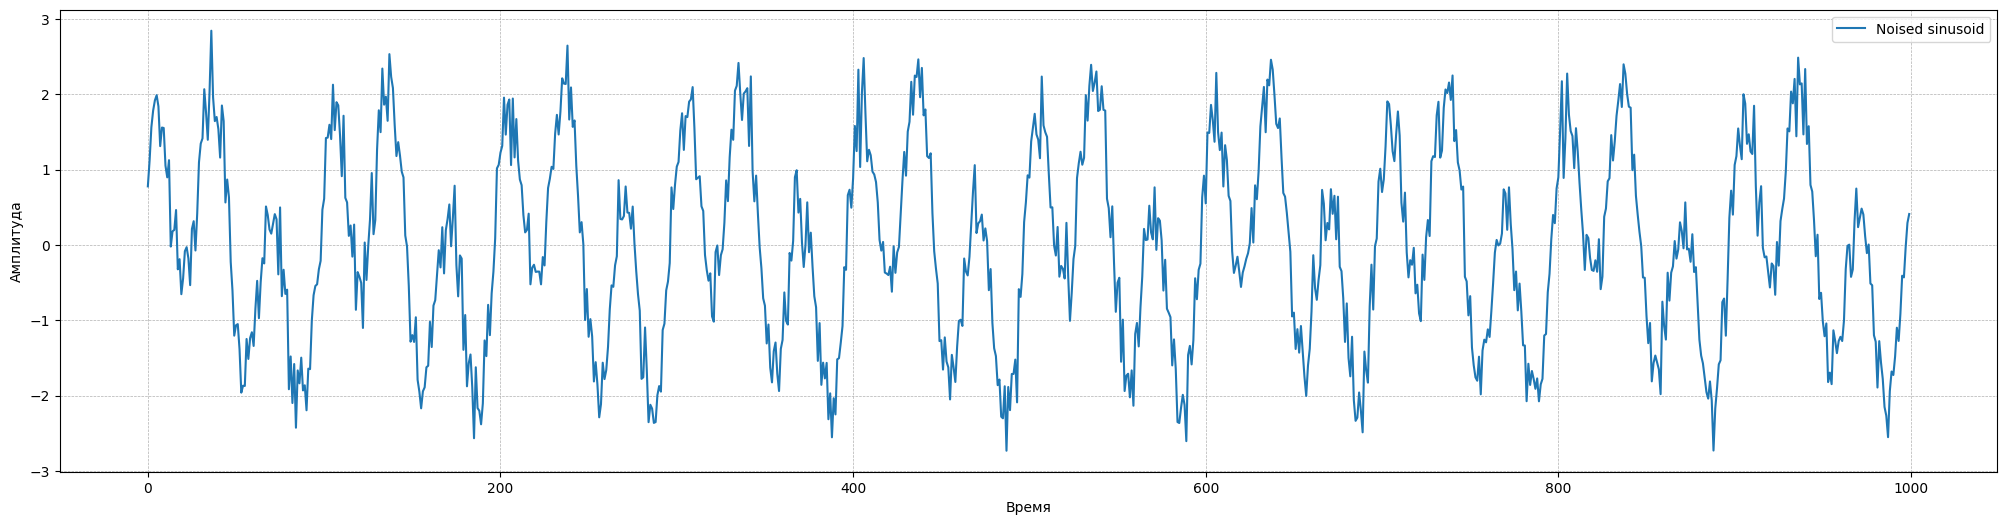

In [43]:
plt.figure(figsize=(25, 6))
plt.plot(signal[:1000], label="Noised sinusoid")
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

In [47]:
def plot_sinusoid(signal):
    plt.figure(figsize=(25, 6))
    plt.plot(signal, label="Noised sinusoid")
    plt.xlabel("Время")
    plt.ylabel("Амплитуда")
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

def split_time_series(signal, min_length, max_length):
    segments = []
    i = 0
    while i < len(signal):
        segment_length = np.random.randint(min_length, max_length + 1)
        if i + segment_length > len(signal):
            break
        segments.append(signal[i:i + segment_length])
        i += segment_length
    return segments

segments = split_time_series(signal, min_length=600, max_length=900)

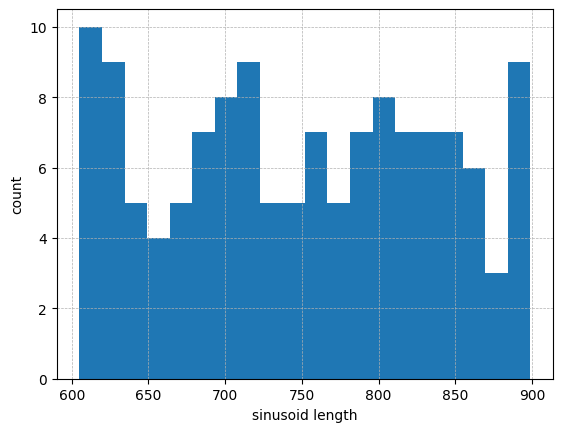

In [48]:
segments_info = [len(segment) for segment in segments]

plt.hist(segments_info, bins=20) 
plt.xlabel("sinusoid length")
plt.ylabel("count")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

In [53]:
len(segments)

133

In [193]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(LSTMAutoencoder, self).__init__()
        # Encoder
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.encoder_fc = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.decoder_output = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, x):
        # print(x.shape)
        # Encoder
        _, (hidden_state, _) = self.encoder_lstm(x)  # hidden_state shape: (1, batch, hidden_dim)
        # print(hidden_state.shape, _.shape)

        latent = self.encoder_fc(hidden_state[-1])   # latent shape: (batch, latent_dim)
        # print(latent.shape)

        # Decoder
        decoder_hidden = self.decoder_fc(latent).unsqueeze(0)  # Convert latent to hidden_dim and add time dimension
        # print(decoder_hidden.shape)
        decoder_input = torch.zeros(x.size(0), x.size(1), self.decoder_lstm.input_size, device=x.device) # Initialize decoder input as zeros
        # print(decoder_input.shape)
        decoder_output, _ = self.decoder_lstm(decoder_input, (decoder_hidden, torch.zeros_like(decoder_hidden)))
        # print(decoder_output.shape)
        output = self.decoder_output(decoder_output)  # Final reconstruction
        
        return output, latent

In [194]:
# segments — список numpy- или torch-тензоров
segments = split_time_series(signal, min_length=600, max_length=900)
segments = [torch.tensor(segment, dtype=torch.float32).unsqueeze(-1) for segment in segments]
packed_segments = pack_sequence(
    segments,
    enforce_sorted=False  # Если ваши сегменты не отсортированы по длине
)

In [195]:
segments[0].shape

torch.Size([899, 1])

In [196]:
padded_output, lengths = pad_packed_sequence(packed_segments, batch_first=True)
first_sequence = padded_output[0, :lengths[0]]      # [seq_len, input_dim]
first_sequence = first_sequence.unsqueeze(0)        # [1, seq_len, input_dim]

print(first_sequence.shape)

torch.Size([1, 899, 1])


torch.Size([1, 899, 1])

In [197]:
model = LSTMAutoencoder(input_dim=1, hidden_dim=128, latent_dim=64)

In [209]:
for segment in segments:
    segment = segment.unsqueeze(0)
    reconstructed, latent = model(segment)
    print(reconstructed.shape, latent.shape)

torch.Size([1, 899, 1]) torch.Size([1, 64])
torch.Size([1, 645, 1]) torch.Size([1, 64])
torch.Size([1, 847, 1]) torch.Size([1, 64])
torch.Size([1, 894, 1]) torch.Size([1, 64])
torch.Size([1, 695, 1]) torch.Size([1, 64])
torch.Size([1, 793, 1]) torch.Size([1, 64])
torch.Size([1, 665, 1]) torch.Size([1, 64])
torch.Size([1, 650, 1]) torch.Size([1, 64])
torch.Size([1, 772, 1]) torch.Size([1, 64])
torch.Size([1, 884, 1]) torch.Size([1, 64])
torch.Size([1, 771, 1]) torch.Size([1, 64])
torch.Size([1, 858, 1]) torch.Size([1, 64])
torch.Size([1, 727, 1]) torch.Size([1, 64])
torch.Size([1, 894, 1]) torch.Size([1, 64])
torch.Size([1, 736, 1]) torch.Size([1, 64])
torch.Size([1, 671, 1]) torch.Size([1, 64])
torch.Size([1, 694, 1]) torch.Size([1, 64])
torch.Size([1, 685, 1]) torch.Size([1, 64])
torch.Size([1, 895, 1]) torch.Size([1, 64])
torch.Size([1, 880, 1]) torch.Size([1, 64])
torch.Size([1, 811, 1]) torch.Size([1, 64])
torch.Size([1, 732, 1]) torch.Size([1, 64])
torch.Size([1, 633, 1]) torch.Si

In [198]:
reconstructed, latent = model(first_sequence)
reconstructed.shape

torch.Size([1, 899, 1])

In [199]:
model(packed_segments)

AttributeError: 'PackedSequence' object has no attribute 'size'

In [185]:
# Распакуйте первую последовательность
padded_output, lengths = pad_packed_sequence(packed_segments, batch_first=True)
first_sequence = padded_output[0, :lengths[0]]  # [1, seq_len, input_dim]

print(first_sequence.shape)

# Пропустите через модель

print(f"Reconstructed shape: {reconstructed.shape}")  # [1, seq_len, 1]
print(f"Latent shape: {latent.shape}")               # [1, 64]

torch.Size([643, 1])


NameError: name 'reconstructed' is not defined

In [99]:
lstm = nn.LSTM(input_size=1, hidden_size=128)
packed_output, (hidden_state, cell_state) = lstm(packed_segments)
packed_output

RuntimeError: output with shape [133, 512] doesn't match the broadcast shape [133, 133, 512]

In [82]:
print(hidden_state.shape)  # (num_layers * num_directions, batch_size, hidden_size)
latent_vectors = hidden_state[-1]  # Берем последнее состояние (для unidirectional LSTM)
print(latent_vectors.shape)  # (batch_size, hidden_size)


torch.Size([1, 133, 128])
torch.Size([133, 128])


In [94]:
padded_output, lengths = pad_packed_sequence(packed_segments, batch_first=True)

first_sequence = padded_output[0, :lengths[0]]  # Извлекаем первую последовательность
first_sequence = first_sequence.unsqueeze(0)  # Добавляем batch размер: [1, seq_len, input_dim]

first_sequence.shape

torch.Size([1, 627, 1])

In [ ]:
# Создаем начальное декодируемое представление
decoder_input = self.decoder_fc(latent).unsqueeze(1).expand(-1, x.size(1), -1)


In [92]:
model = LSTMAutoencoder(input_dim=1, hidden_dim=128, latent_dim=64)
reconstructed, latent = model(first_sequence)

RuntimeError: input.size(-1) must be equal to input_size. Expected 128, got 1